<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Colab" data-toc-modified-id="Colab-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Colab</a></span></li><li><span><a href="#Import" data-toc-modified-id="Import-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Import</a></span></li><li><span><a href="#Loading" data-toc-modified-id="Loading-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Loading</a></span><ul class="toc-item"><li><span><a href="#extra-one-hot-features" data-toc-modified-id="extra-one-hot-features-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>extra one-hot features</a></span></li><li><span><a href="#extra-keywords" data-toc-modified-id="extra-keywords-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>extra keywords</a></span></li></ul></li><li><span><a href="#BERT" data-toc-modified-id="BERT-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>BERT</a></span></li></ul></div>

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#TextCNN" data-toc-modified-id="TextCNN-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>TextCNN</a></span><ul class="toc-item"><li><span><a href="#notes:" data-toc-modified-id="notes:-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>notes:</a></span></li></ul></li><li><span><a href="#LSTM" data-toc-modified-id="LSTM-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>LSTM</a></span></li></ul></div>

# Colab

In [1]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir("/content/drive/MyDrive/Text-Classification/code")
!pip install pyLDAvis
!pip install gensim
!pip install pandas==1.3.0

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Import 

In [2]:
from classification_utils import *
from clustering_utils import *
from eda_utils import *
from nn_utils_keras import *
from feature_engineering_utils import *
from data_utils import *
import warnings 
warnings.filterwarnings("ignore")

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!


# Loading

In [3]:
train, test = load_data(only_stem_voc=False, sample50=False)
train, upsampling_info = upsampling_train(train)
# train_text, train_label = train_augmentation(train, select_comb=[['text']])
# train_text, train_label = train_augmentation(train, select_comb=[['reply', 'reference_one', 'reference_two']])
train_text, train_label = train_augmentation(train, select_comb=[[  'Subject','Organization', 'reply', 'reference_one']])
# train_text, train_label = train['text'], train['label']
# test_text, test_label = test['text'], test['label']
test_text, test_label = test[[ 'Subject', 'Organization', 'reply', 'reference_one']].apply(lambda x: " ".join(x), axis=1), test['label']


# test_text = test_text.apply(lambda x: extract_stem_voc(x))
# train_text = train_text.apply(lambda x: extract_stem_voc(x))
# train_text.to_csv("stem_voc_train.csv")
# test_text.to_csv("stem_voc_test.csv")

# train_text, test_text = load_stem_voc()
train_text.sample(5).tolist()
upsampling_info


may use cols: 
 ['global_index', 'doc_path', 'label', 'reply', 'reference_one', 'reference_two', 'tag_reply', 'tag_reference_one', 'tag_reference_two', 'Subject', 'From', 'Lines', 'Organization', 'contained_emails', 'long_string', 'text', 'error_message']
combination 1 train:  ['Subject', 'Organization', 'reply', 'reference_one']


,before_upsampling,after_upsampling,increase
label,,,
alt.atheism,480,554,74
comp.graphics,584,584,0
comp.os.ms-windows.misc,591,591,0
comp.sys.ibm.pc.hardware,590,590,0
comp.sys.mac.hardware,578,578,0
comp.windows.x,593,593,0
misc.forsale,585,585,0
rec.autos,593,593,0
rec.motorcycles,598,598,0


In [4]:
train, test = load_data(only_stem_voc=False, sample50=False)
train.columns# ['Summary']


may use cols: 
 ['global_index', 'doc_path', 'label', 'reply', 'reference_one', 'reference_two', 'tag_reply', 'tag_reference_one', 'tag_reference_two', 'Subject', 'From', 'Lines', 'Organization', 'contained_emails', 'long_string', 'text', 'error_message']


Index(['global_index', 'doc_path', 'label', 'reply', 'reference_one',
       'reference_two', 'tag_reply', 'tag_reference_one', 'tag_reference_two',
       'Subject', 'From', 'Lines', 'Organization', 'contained_emails',
       'long_string', 'text', 'error_message'],
      dtype='object')

In [5]:
####################################
### label mapper
####################################
labels = sorted(train_label.unique())
label_mapper = dict(zip(labels, range(len(labels))))
train_label = train_label.map(label_mapper)
test_label = test_label.map(label_mapper)
y_train = train_label
y_test = test_label

print(train_text.shape)
print(test_text.shape)
print(train_label.shape)
print(test_label.shape)
print(labels)

(11813,)
(7761,)
(11813,)
(7761,)
['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']


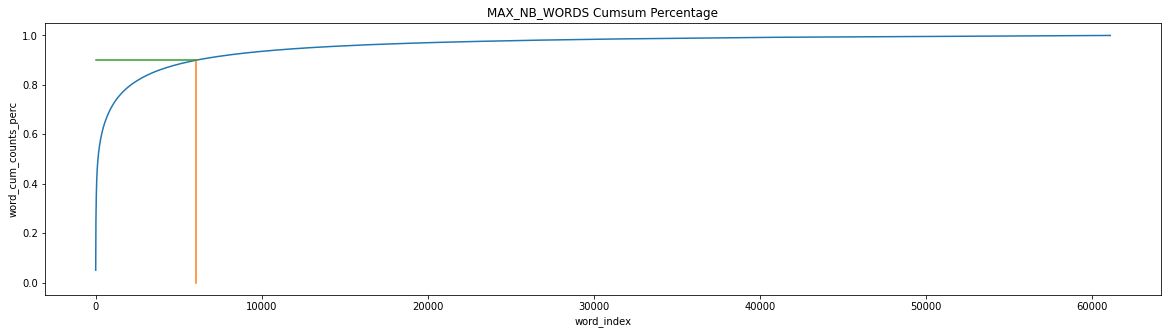

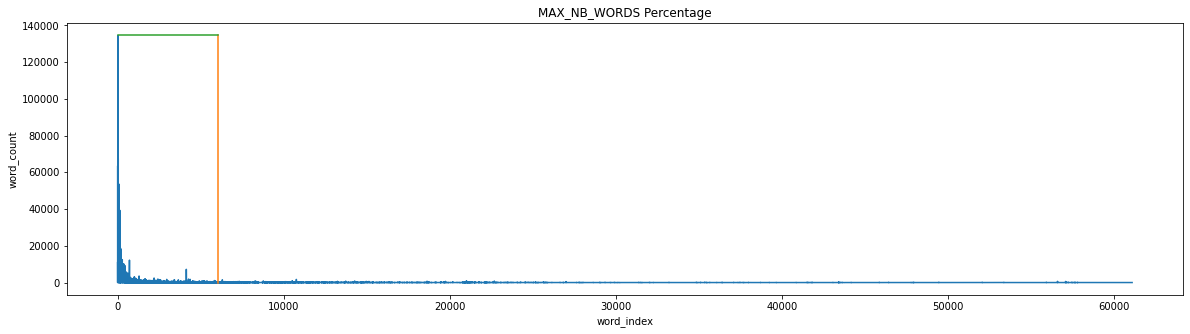

Cut index with 90.0 % of corpus:  6060 

    index  word   count
0      31   the  134581
1      41    to   67385
2       6    of   63541
3      26     a   56899
4      82   and   53612
5      13     i   45779
6      39    is   40097
7     134    in   39348
8      76  that   36943
9      38    it   30871
10     44   for   26016
11     19   you   25308
12    177    on   18725
13     16  this   18494
14    190     s   17993
15     42    be   17504
16     92   are   17379
17     60  have   16723
18     78   not   16352
19     56  with   15941
extreme frequent words:    word   count
6    of   63541
26    a   56899
31  the  134581
41   to   67385
82  and   53612


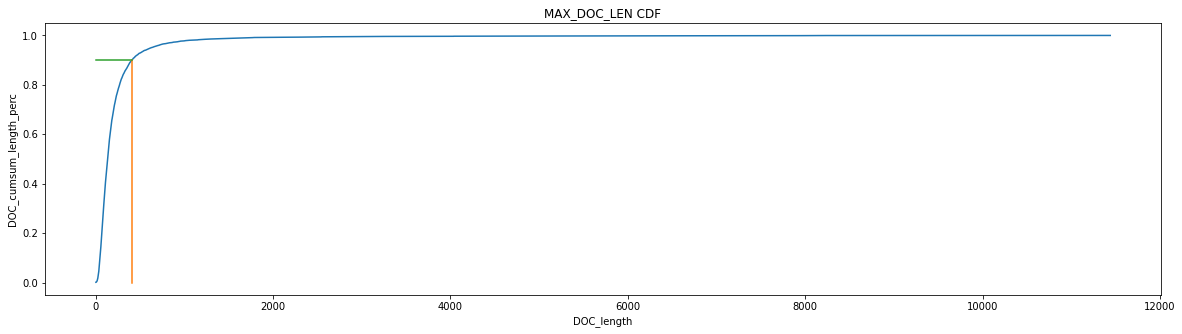

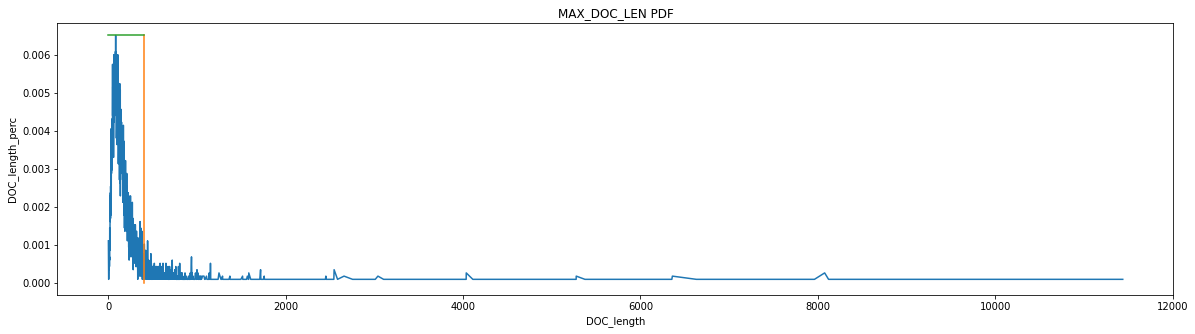

Cut index with 90.0 % of corpus:  408


In [6]:
####################################
### hyper params 
####################################
filters = '"#$%&()*+,-/:;<=>@[\\]^_`{|}~\t\n0123465789!.?\''
MAX_NB_WORDS_ratio = 0.90
MAX_DOC_LEN_ratio = 0.90
MAX_NB_WORDS = eda_MAX_NB_WORDS(train_text, ratio=MAX_NB_WORDS_ratio, char_level=False, filters=filters)
MAX_DOC_LEN = eda_MAX_DOC_LEN(train_text, ratio=MAX_DOC_LEN_ratio, char_level=False, filters=filters)

In [7]:
# X_train, X_test, word_to_idx, tfidf_vect = tfidf_vectorizer(train_text, test_text, stop_words=True, binary=True, min_df=5)
# X_train, transform_mapper = dimension_reduction(X_train, out_dim=1000) # not allow negative 
# X_test = transform_mapper.transform(X_test)

## extra one-hot features

In [8]:
# one_hot_X_train, one_hot_X_test, one_hot_word_to_idx, one_hot_count_vect = count_vectorizer(
#     train['Subject']+" " + train['Organization'], test['Subject']+" " + test['Organization'], stop_words=True, binary=False, min_df=3, max_df=0.001)

## extra keywords

In [9]:
# label_docs = train.groupby('label')['text'].apply(lambda x: " ".join(x)) # 要去除标点符号
# dtm, _, label_word_to_idx, _ = count_vectorizer(label_docs, [''], stop_words=True, min_df=1, binary=True)
# label_idx_to_word = dict([val, key] for key, val in label_word_to_idx.items())
# keywords_threshold = 1
# keywords_idx = np.where(dtm.sum(axis=0)<=keywords_threshold)[0]
# print(" keywords_idx shape: ")
# voc = [label_idx_to_word[idx] for idx in keywords_idx]

# keywords_X_train, keywords_X_test, keywords_word_to_idx, keywords_count_vect = count_vectorizer(
#     train['text'], test['text'], voc=voc, stop_words=True, min_df=1, binary=True)

In [10]:
# _X_train = np.hstack([X_train])
# _X_test = np.hstack([X_test])
# _X_train = np.hstack([X_train, one_hot_X_train, keywords_X_train])
# _X_test = np.hstack([X_test, one_hot_X_test, keywords_X_test])

# BERT

In [11]:
!pip install transformers
!pip install torchinfo
import torch
import torch.nn.functional as F

from torchinfo import summary
from transformers import BertTokenizer, BertModel, AdamW, BertConfig, get_linear_schedule_with_warmup, BertForSequenceClassification

from bert_utils.training_utils import extract_contextual_embedding, train_multi_label_model, model_eval
from bert_utils.data_loader import  data_loader_BERT
from bert_utils import glovar 
from bert_utils.model import *




Append path:  /content/drive/My Drive/Text-Classification/code/bert_utils
My Linux system:  Linux
using:  cuda
My Linux system:  Linux
using:  cuda


In [12]:
train_one_hot_labels = F.one_hot(torch.tensor(y_train.values))
test_one_hot_labels = F.one_hot(torch.tensor(test_label.values))

In [13]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained("bert-base-uncased", output_attentions = True, output_hidden_states = True)
# bert_model = BertForSequenceClassification.from_pretrained( "bert-base-uncased", num_labels=20, output_attentions=True, output_hidden_states=True,)
# global device
device = glovar.device_type
bert_model = bert_model.to(device)
print(next(bert_model.parameters()).device)  # 输出：cpu
summary(bert_model)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


cuda:0


Layer (type:depth-idx)                             Param #
BertModel                                          --
├─BertEmbeddings: 1-1                              --
│    └─Embedding: 2-1                              23,440,896
│    └─Embedding: 2-2                              393,216
│    └─Embedding: 2-3                              1,536
│    └─LayerNorm: 2-4                              1,536
│    └─Dropout: 2-5                                --
├─BertEncoder: 1-2                                 --
│    └─ModuleList: 2-6                             --
│    │    └─BertLayer: 3-1                         7,087,872
│    │    └─BertLayer: 3-2                         7,087,872
│    │    └─BertLayer: 3-3                         7,087,872
│    │    └─BertLayer: 3-4                         7,087,872
│    │    └─BertLayer: 3-5                         7,087,872
│    │    └─BertLayer: 3-6                         7,087,872
│    │    └─BertLayer: 3-7                         7,087,872
│    │   

In [14]:
load_embed= False
finetune = True

learning_rate = 0.00005
epochs = 20
patience = 60
MAX_DOC_LEN = 300
batch_size = 32


max_len = min(512, MAX_DOC_LEN)
label_size = 20
label_cols = labels
embed_dim = 768
hidden_units = 64
num_filters = 30
kernel_sizes = [1,2,3]
embed_type=3

setup_seed(2021)

NameError: ignored

In [ ]:
if load_embed is True:
    train_sentences_encoding = np.load(f'train_sentences_encoding_{finetune}_{embed_type}.npy')# , mmap_mode='r')
    train_input_ids = np.load(f'train_input_ids_{finetune}_{embed_type}.npy')#, mmap_mode='r')
    train_sentences_encoding = torch.tensor(train_sentences_encoding)
    train_input_ids = torch.tensor(train_input_ids)
else:
    train_input_ids, train_sentences_encoding, train_attention_masks = extract_contextual_embedding(train_text, tokenizer, bert_model, finetune=finetune, max_len = max_len, low_RAM_inner_batch=True, embed_type=embed_type)
    # train_input_ids, train_sentences_encoding = extract_contextual_embedding(train_text.iloc[1:3], tokenizer, bert_model, max_len = max_len, low_RAM_inner_batch=False) test
    np.save(f'train_sentences_encoding_{finetune}_{embed_type}.npy', train_sentences_encoding)
    np.save(f'train_input_ids_{finetune}_{embed_type}.npy', train_input_ids)

## for finetune version train_sentences_encoding is the attention mask
dataloader, validation_dataloader = data_loader_BERT(train_sentences_encoding, train_input_ids, train_attention_masks, train_one_hot_labels, 
                                                                                            batch_size, random_state=1234, test_size=0.1)
del train_sentences_encoding, train_input_ids

In [ ]:

model_path = 'bert_clf_v3.pt'
label_size = len(labels)


if finetune:
    model = clf_finetuneBERT(freeze_bert=False, num_classes=label_size, hidden_units=hidden_units)
    # dataloader 会不一样
else:    
    # model = lstm_cnn_o1(embed_dim, max_len, hidden_units, num_filters, kernel_sizes, label_size)
    # model = lstm_cnn_o2(embed_dim, max_len, hidden_units, num_filters, kernel_sizes, label_size)
    # model = clf(embed_dim, max_len, hidden_units, label_size)
    model = clf_naive(embed_dim, max_len, hidden_units, label_size, dropout_rate=0.0)    

model.to(device)

In [ ]:
[torch.cuda.empty_cache() for _ in range(10) ]
print(torch.cuda.memory_summary())

In [ ]:
# Data Loader

optimizer = AdamW(model.parameters(), lr=learning_rate, eps=1e-8)
total_steps = len(dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=int(total_steps * 0.1), num_training_steps=total_steps)


model, training_stats, pred_labels, true_labels = train_multi_label_model(model, label_size, label_cols, dataloader, validation_dataloader, finetune=finetune, optimizer=optimizer, scheduler=scheduler, epochs=epochs, patience=patience, model_path=model_path)


pd.set_option('precision', 2)
df_stats = pd.DataFrame(data=training_stats)
df_stats = df_stats.set_index('epoch')
df_stats.to_csv(model_path[0:-2] + 'csv')

import seaborn as sns
sns.set(style='darkgrid')
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12, 6)
plt.plot(df_stats['train_loss'], 'b-o', label="Training")
plt.plot(df_stats['val_loss'], 'g-o', label="Validation")
plt.legend()
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.xticks(list(range(1, epochs + 1)))
plt.show()

In [ ]:
# model.load_state_dict(torch.load(model_path))
[torch.cuda.empty_cache() for _ in range(10) ]
print(torch.cuda.memory_summary())

In [ ]:
if load_embed is True:
    
    test_sentences_encoding = np.load(f'test_sentences_encoding_{finetune}_{embed_type}.npy')#, mmap_mode='r')
    test_input_ids = np.load(f'test_input_ids_{finetune}_{embed_type}.npy') # , mmap_mode='r')
    test_sentences_encoding = torch.tensor(test_sentences_encoding)
    test_input_ids = torch.tensor(test_input_ids)
else:
    test_input_ids, test_sentences_encoding, test_attention_masks = extract_contextual_embedding(test_text, tokenizer, bert_model, finetune=finetune, max_len = max_len, low_RAM_inner_batch=True, embed_type=embed_type)
    np.save(f'test_sentences_encoding_{finetune}_{embed_type}.npy', test_sentences_encoding)
    np.save(f'test_input_ids_{finetune}_{embed_type}.npy', test_input_ids)


test_dataloader, _ = data_loader_BERT(test_sentences_encoding,test_input_ids, test_attention_masks, test_one_hot_labels, batch_size=batch_size, testing=True)
del test_sentences_encoding, test_input_ids

tokenized_texts, pred_labels, true_labels, avg_val_loss, auc_score, precison, recall, acc, f1 = model_eval(model, test_dataloader,  labels , finetune=finetune, class_weight=None)
classification_report = evaluation_report(np.argmax(true_labels, axis=1),  np.argmax(pred_labels, axis=1), labels=labels)
roc_auc(y_test, pred_labels)

In [ ]:
import re
from collections import Counter
import pandas as pd
import torch
from sklearn.model_selection import train_test_split  # , StratifiedKFold
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import numpy as np


In [ ]:
df_stats